<h1> ElectroMagnetic Simulator </h1>

<h2> Setup </h2>
<h3> Import Libraries </h3>

In [1]:

import numpy as np
import matplotlib as mp
from matplotlib.pyplot import plot

import pdb
np.seterr(all='raise')

import ipywidgets as widgets


%matplotlib inline

ModuleNotFoundError: ignored

<h3> Length and Timescale </h3>

In [0]:
Domain_length = np.array([0.5, 0.5])                # Meters
Simulation_Duration = 1*10**-8   # Seconds

<h3> Material Parameters </h3>

In [0]:
speed_of_light = 3*10**8        # Meters / Second

<h3> Simulation parameters </h3>

<h3> Input Function </h3>

In [0]:
frequency = 2*10**9
input_duration = 13 # Measured in timesteps

In [5]:
no_of_dimensions = np.size(Domain_length)

# Mesh and timestep sizing
Elements_per_Wavelength = 14
TimeSteps_per_Wavelength = 25

Element_Length = np.ones(no_of_dimensions) * speed_of_light / [(frequency * Elements_per_Wavelength)]
no_of_elements = (Domain_length/Element_Length).astype(int)
print("Element Length: {}".format(Element_Length))
print("Number of Elements: {}".format(no_of_elements))


timestep_size = 1/(frequency*TimeSteps_per_Wavelength)
no_of_timesteps = int(Simulation_Duration/timestep_size)
print("Number of Timesteps: {}".format(no_of_timesteps))

print("CFL no.: {}".format(sum(speed_of_light * timestep_size / Element_Length)))
alpha = (speed_of_light * timestep_size / Element_Length[0])**2
print("alpha:{}".format(alpha))
print("alpha:{} dB".format(10*np.log10((speed_of_light * timestep_size / Element_Length[0])**2)))

Element Length: [0.01071429 0.01071429]
Number of Elements: [46 46]
Number of Timesteps: 500
CFL no.: 1.1199999999999999
alpha:0.31359999999999993
alpha:-5.036239459875993 dB


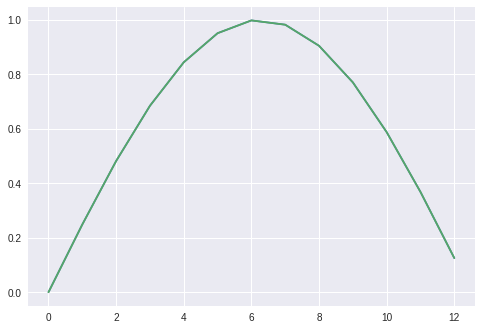

In [6]:
# window_function = np.array([np.sin(np.pi * t/input_duration) for t in range(input_duration)])
input_function = np.array([np.sin(2*np.pi*frequency * timestep_size*t) for t in range(input_duration)], np.double)
# input_function *= window_function
input_function.resize(no_of_timesteps)

for dim in range(no_of_dimensions):
    plot(range(input_duration),input_function[:input_duration])
    

<h3> Pre-Calculation Steps </h3>

In [0]:
speed_of_light_squared_x_timestep_sq = (speed_of_light**2) * (timestep_size**2)

cartesian_vector = np.zeros(no_of_dimensions)

# Initial Values
Initial_E = cartesian_vector
Initial_B = cartesian_vector

<h3> Element Base Class </h3>

In [0]:
class BaseElement():
    '''
    Base class for Elemenets
    '''
    Last_ID = 0
    def __init__(self, coords, length):
        
        # Element IDs
        BaseElement.Last_ID += 1
        self.ID = BaseElement.Last_ID
        
        # Coordinates
        self.coordinates = coords
        self.length = length
        self.reciprocal_length = 1/self.length
        
        # Electromagnetic Properties
        self.E = np.array([Initial_E for i in range(no_of_timesteps)])
        self.B = np.array([Initial_B for i in range(no_of_timesteps)])
        
        self.positive_neighbours = np.array([None for i in range(no_of_dimensions)], dtype = object)
        self.negative_neighbours = self.positive_neighbours.copy()
        
        
    def link(self, elem, direction):
        '''
        Links two elements for calculations.
        Directions are to be specified as: [x+, y+, z+]
        '''
        self.positive_neighbours[direction] = elem
        elem.negative_neighbours[direction] = self
    


<h3> Boundary Condition Element </h3>

In [0]:
class BoundaryElement(BaseElement):
    '''
    Element with pre-determined values through time
    '''
    def __init__(self, coords, length):
        BaseElement.__init__(self, coords, length)

    def SetE(self, direction, E_Array):
        self.E[:,direction] = E_Array
    
    def SetB(self, direction, B_Array):
        self.B[:][direction] = B_Array 
        
    def Calculate(self, timestep_to_calculate):
        pass

<h3> Standard Element </h3>

In [0]:
class Element(BaseElement):
    '''
    Element to be solved in the simulation
    '''
    def __init__(self, coords, length):
        BaseElement.__init__(self, coords, length)
        self.LastSolvedTimestep = 1
        
        
        
    def Calculate(self, timestep_to_calculate):
        
        # re-define for shorter syntax
        t = timestep_to_calculate
        prev_t =  t-1
        
        dEdt2 = np.zeros(np.shape(Initial_E))
        dBdt2 = np.zeros(np.shape(Initial_B))
        
        for dim in range(no_of_dimensions):
            
            try:
                # Calculate Spatial Derivatives
                forward_derivatives_E = (self.positive_neighbours[dim].E[prev_t] - self.E[prev_t]) * self.reciprocal_length
                backward_derivatives_E = ( - self.negative_neighbours[dim].E[prev_t] + self.E[prev_t]) * self.reciprocal_length
                forward_derivatives_B = (self.positive_neighbours[dim].B[prev_t] - self.B[prev_t]) * self.reciprocal_length
                backward_derivatives_B = ( - self.negative_neighbours[dim].B[prev_t] + self.B[prev_t]) * self.reciprocal_length
            
                if 0:
                    print("coordinates: {}".format(self.coordinates))
                    print("time to evaluate: {}".format(t))
                    print("Dimension: {}".format(dim))

                    print(forward_derivatives_E)
                    print(backward_derivatives_E) 
                    print(forward_derivatives_B)
                    print(backward_derivatives_B) 

            except FloatingPointError:
                pdb.set_trace()

            try:
                # Calculate Second time gradient
                dEdt2 += speed_of_light_squared_x_timestep_sq * (forward_derivatives_E - backward_derivatives_E) * self.reciprocal_length
                dBdt2 += speed_of_light_squared_x_timestep_sq * (forward_derivatives_B - backward_derivatives_B) * self.reciprocal_length
            
                if 0:
                    print("Value to add: dEdt2 = {0}, E[t-1] = {1}, E[t-2] = {2}".format(dEdt2 , 2*self.E[prev_t] , self.E[t-2]))

            except FloatingPointError:
                pdb.set_trace()
                
                
        try:

            # Calculate New E and B values for the timestep
                
                
            self.E[t] = dEdt2 + 2*self.E[prev_t] - self.E[t-2]
            self.B[t] = dBdt2 + 2*self.B[prev_t] - self.B[t-2]
                
        except FloatingPointError:
            pdb.set_trace()
                
                

                
        
        if 0:
            print("E-field Final: {}".format(self.E[t]))
            print("****************")
            print("")
        

<h3> Element Array Builder </h3>

In [0]:

def Element_Array_builder():
    
    # Create Coordinate Array as an array of X-coordiante, Y-Coordinate and Z-Coordinate grids of element x element
    Coordinate_Array = np.array([np.ones(no_of_elements) for dim in range(no_of_dimensions)])

    # Populate the Coordinate matrix, assuming constant Element Length
    for dim in range (no_of_dimensions):
        axis = Coordinate_Array[dim]
        for indices, point in np.ndenumerate(axis):
                axis[indices] = Element_Length[dim] * indices[dim]

    # Assume maximum and minimum values - used to determine boundary elements
    Min_vals = np.zeros(no_of_dimensions)
    Max_vals = Element_Length*(no_of_elements-1)
    
    
    # Create a Boundary Element mask array
    Boundary_Array = np.zeros(no_of_elements, dtype = bool)
    for dim in range(no_of_dimensions):
        Boundary_Array += (Coordinate_Array[dim] == Min_vals[dim]) + (Coordinate_Array[dim] == Max_vals[dim])

    # Initialise the Element Array
    Element_Array = np.empty(no_of_elements , dtype = object)
    
    # Populate the Element Array with either Boundary Elements or regular Elements, using the Boundary_Array mask
    for indices, coords in np.ndenumerate(Boundary_Array):
        
        # Gather the coordinates for the Element
        coordinates = np.zeros(no_of_dimensions)
        for dim in range(no_of_dimensions):
            coordinates[dim] = Coordinate_Array[dim][indices]
        if Boundary_Array[indices]:
            Element_Array[indices] = BoundaryElement(coordinates, Element_Length)
            
        else:
            Element_Array[indices] = Element(coordinates, Element_Length)


    
    # LINK ELEMENTS
    for index, elem in np.ndenumerate(Element_Array):
        for dim in range(no_of_dimensions):
            if index[dim] < no_of_elements[dim]-1:
                neighbour_index = list(index)
                neighbour_index[dim] += 1
                neighbour_index = tuple(neighbour_index)
                elem.link(Element_Array[neighbour_index], dim)

        
    return Element_Array


<h3> Test </h3>

In [0]:
A = Element_Array_builder()
A[0, 1 ].SetE(0 ,input_function)

In [0]:
for t in range(3,no_of_timesteps):
    for index, elem in np.ndenumerate(A):
        try:
            A[index].Calculate(t)
        except AttributeError:
            pass

In [14]:
A[0,1].E[0:5]/Element_Length[0]

array([[ 0.        ,  0.        ],
       [23.21105614,  0.        ],
       [44.96367625,  0.        ],
       [63.89106322,  0.        ],
       [78.80393971,  0.        ]])

In [15]:

gain = lambda t,x,y: (A[x,y].E[t][0] / A[x,y].E[t-1][0])
print_gain = lambda t,x,y:print("{} \n".format(gain(t,x,y)) )

rng = [10,1000]
x = 2
y = 1

res = [gain(i,x,y) for i in range(rng[0], rng[1])]

mp.pyplot.figure(figsize = (20,10))
mp.pyplot.axis([0, rng[1], 0, res[0] ])
mp.pyplot.plot(range(rng[0], rng[1]), res)

test1 = np.array([i+1 for i in range(rng[0],rng[1])])
mp.pyplot.plot(test1, np.e**(-test1*alpha) +3.5)

print_gain(rng[0],x,y)
print_gain(rng[1],x,y)

print_gain(30,x,y)

IndexError: ignored

In [0]:
if no_of_dimensions == 1:
    t_steps = 5
    for t in range(0,int(no_of_timesteps/40), t_steps):
        mp.pyplot.figure(figsize = (20,10))
        mp.pyplot.axis([0,xelements, -2,2])
        Es = [elem.E[t] for elem in A]
        plot(range(0,len(A)), Es)

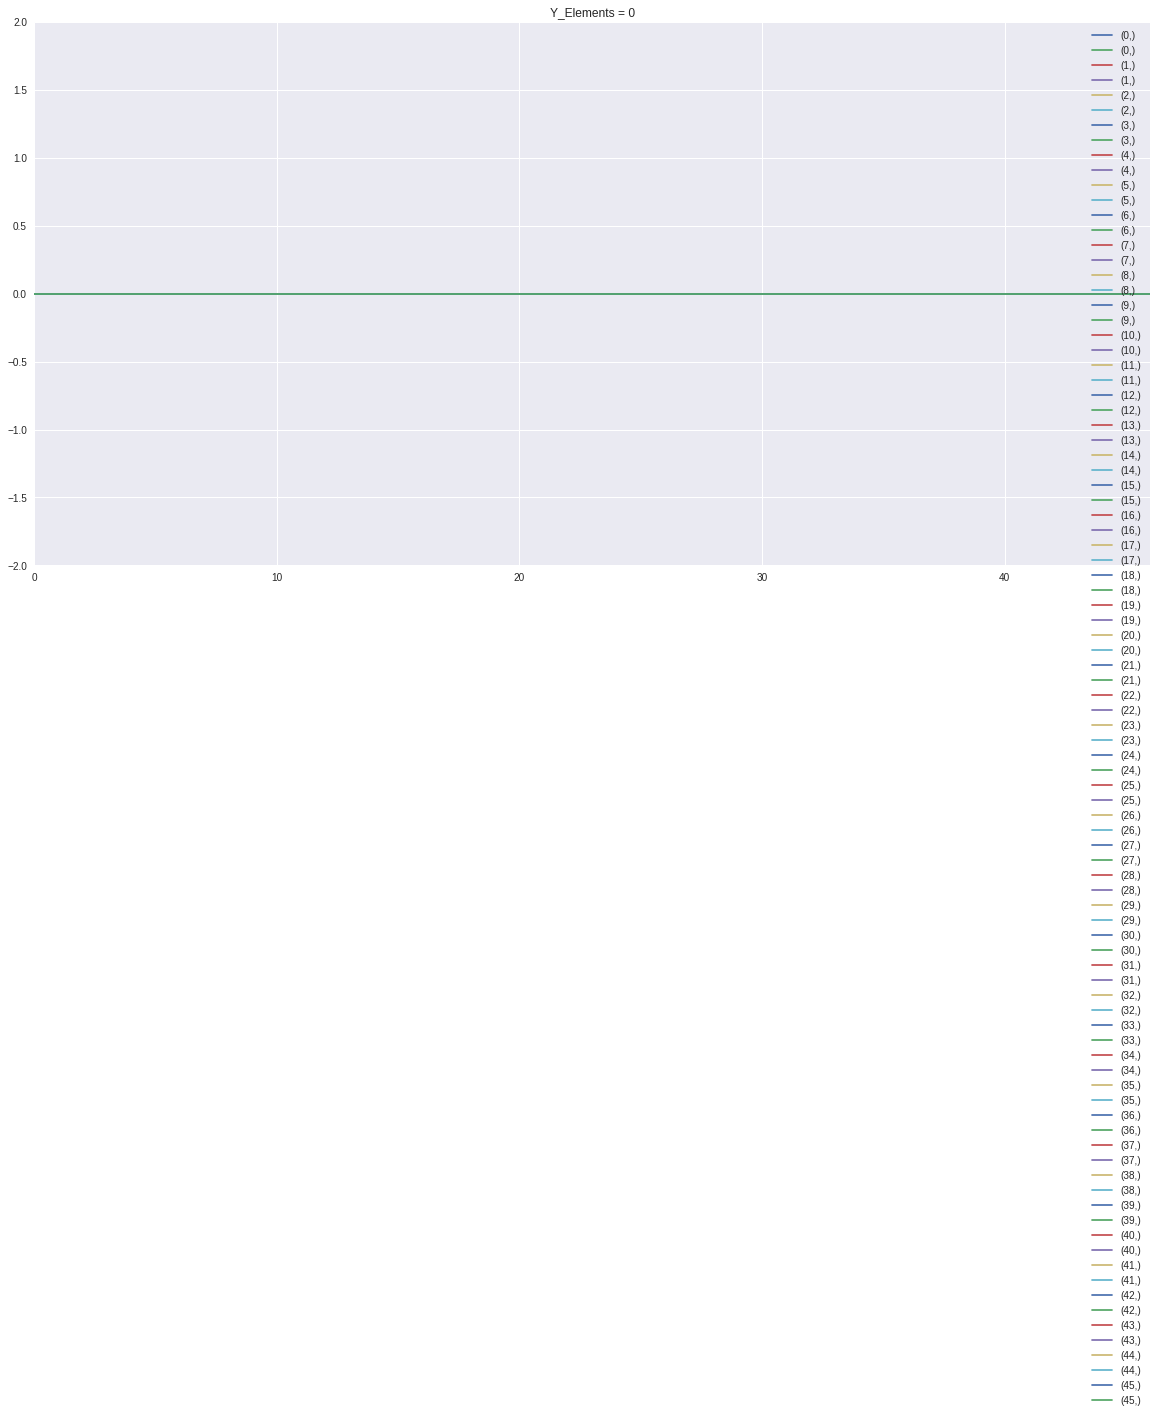

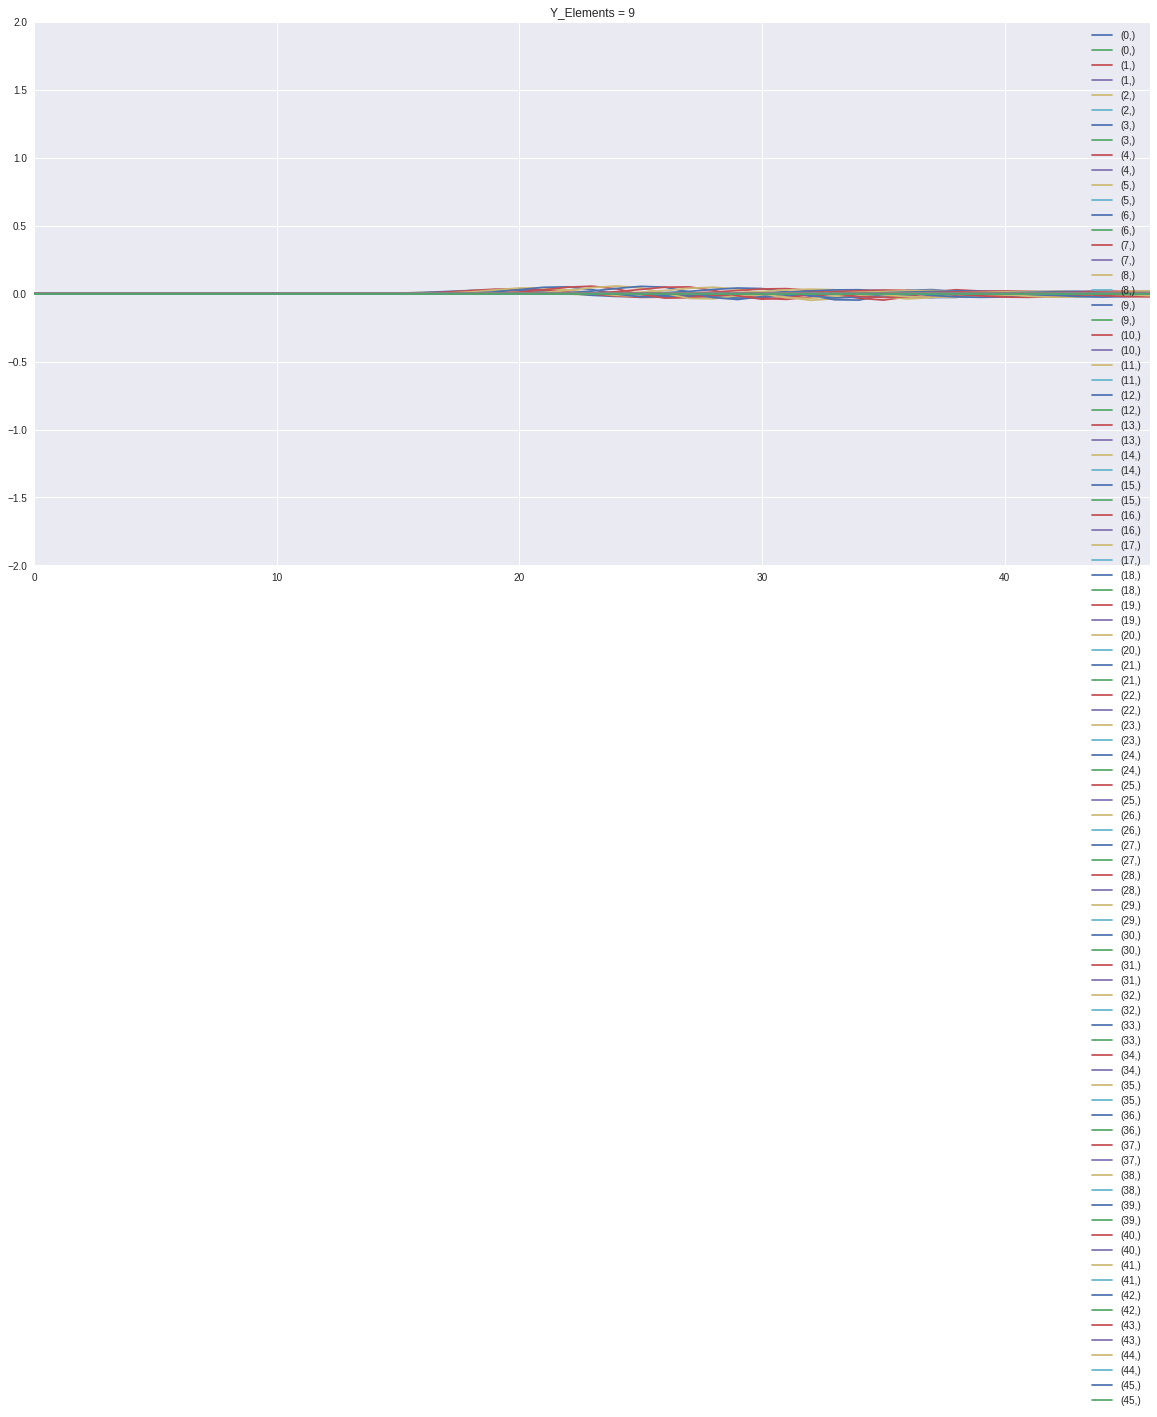

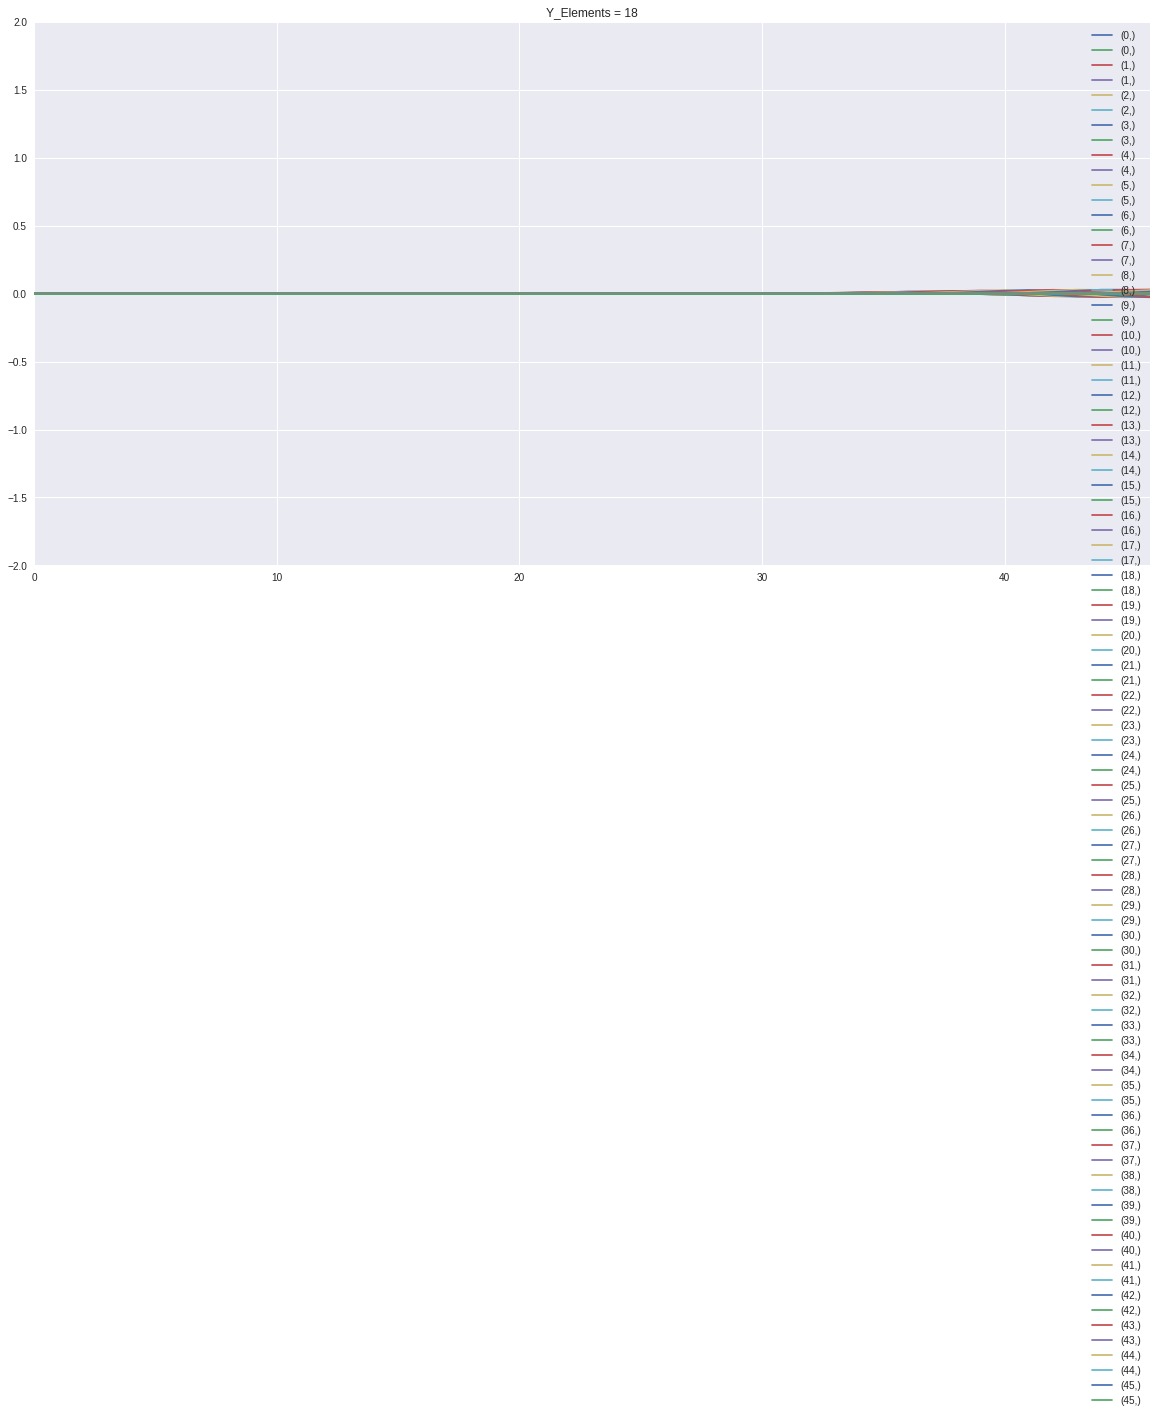

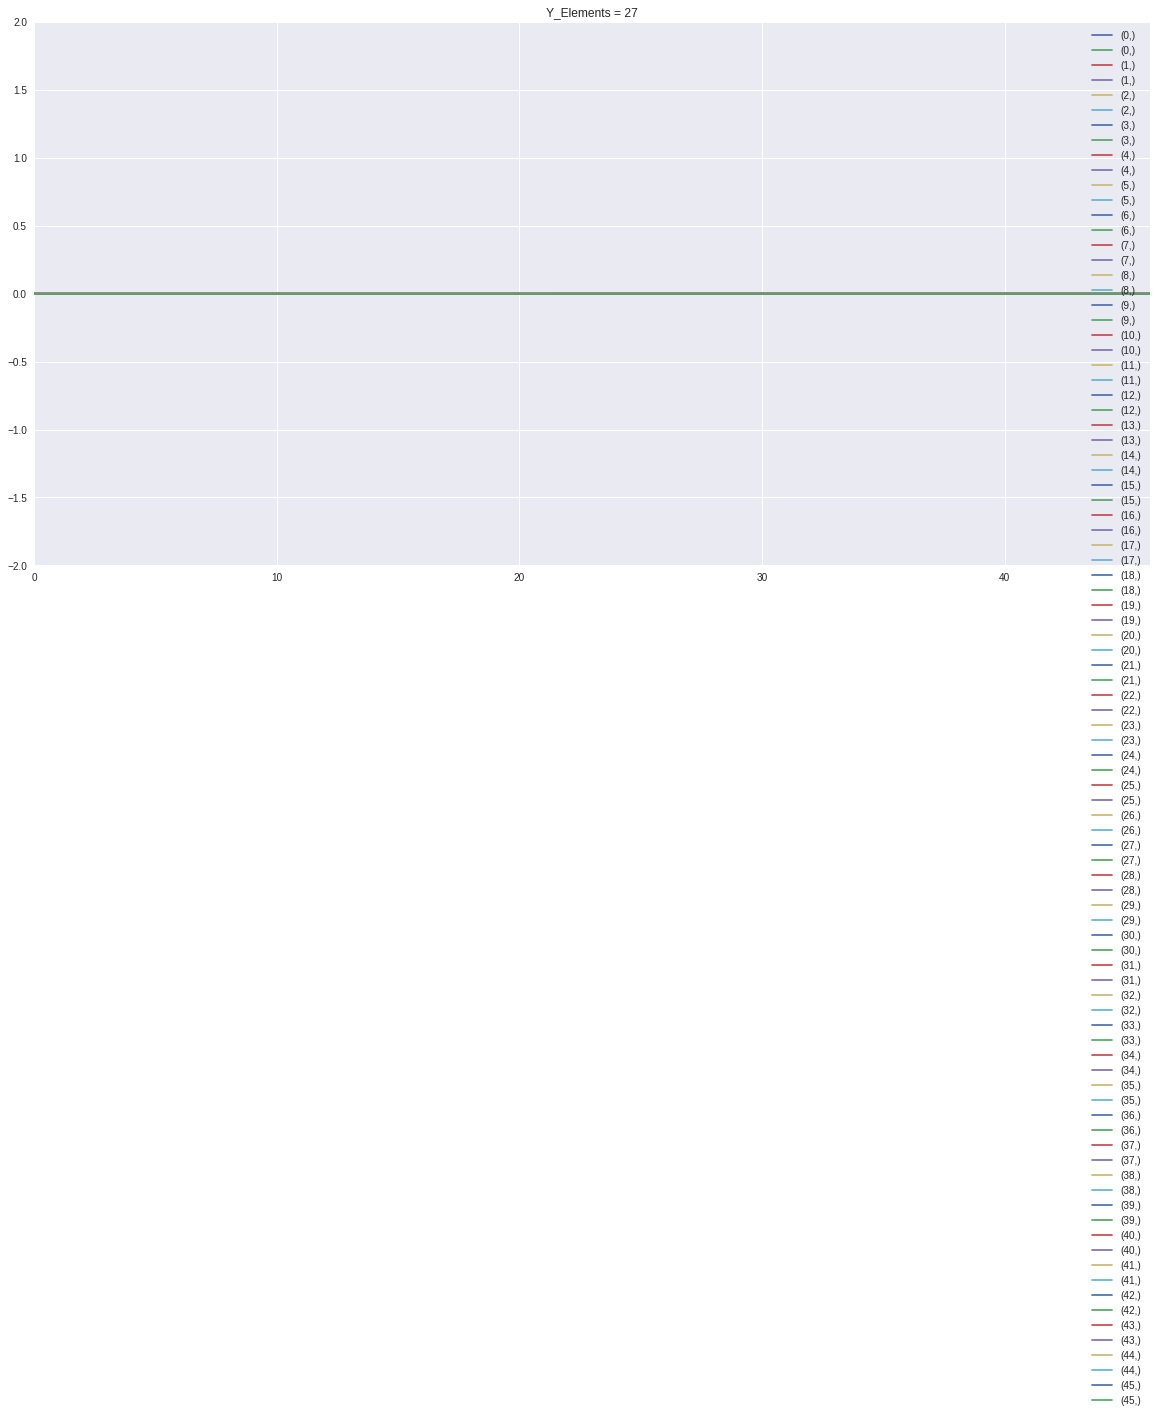

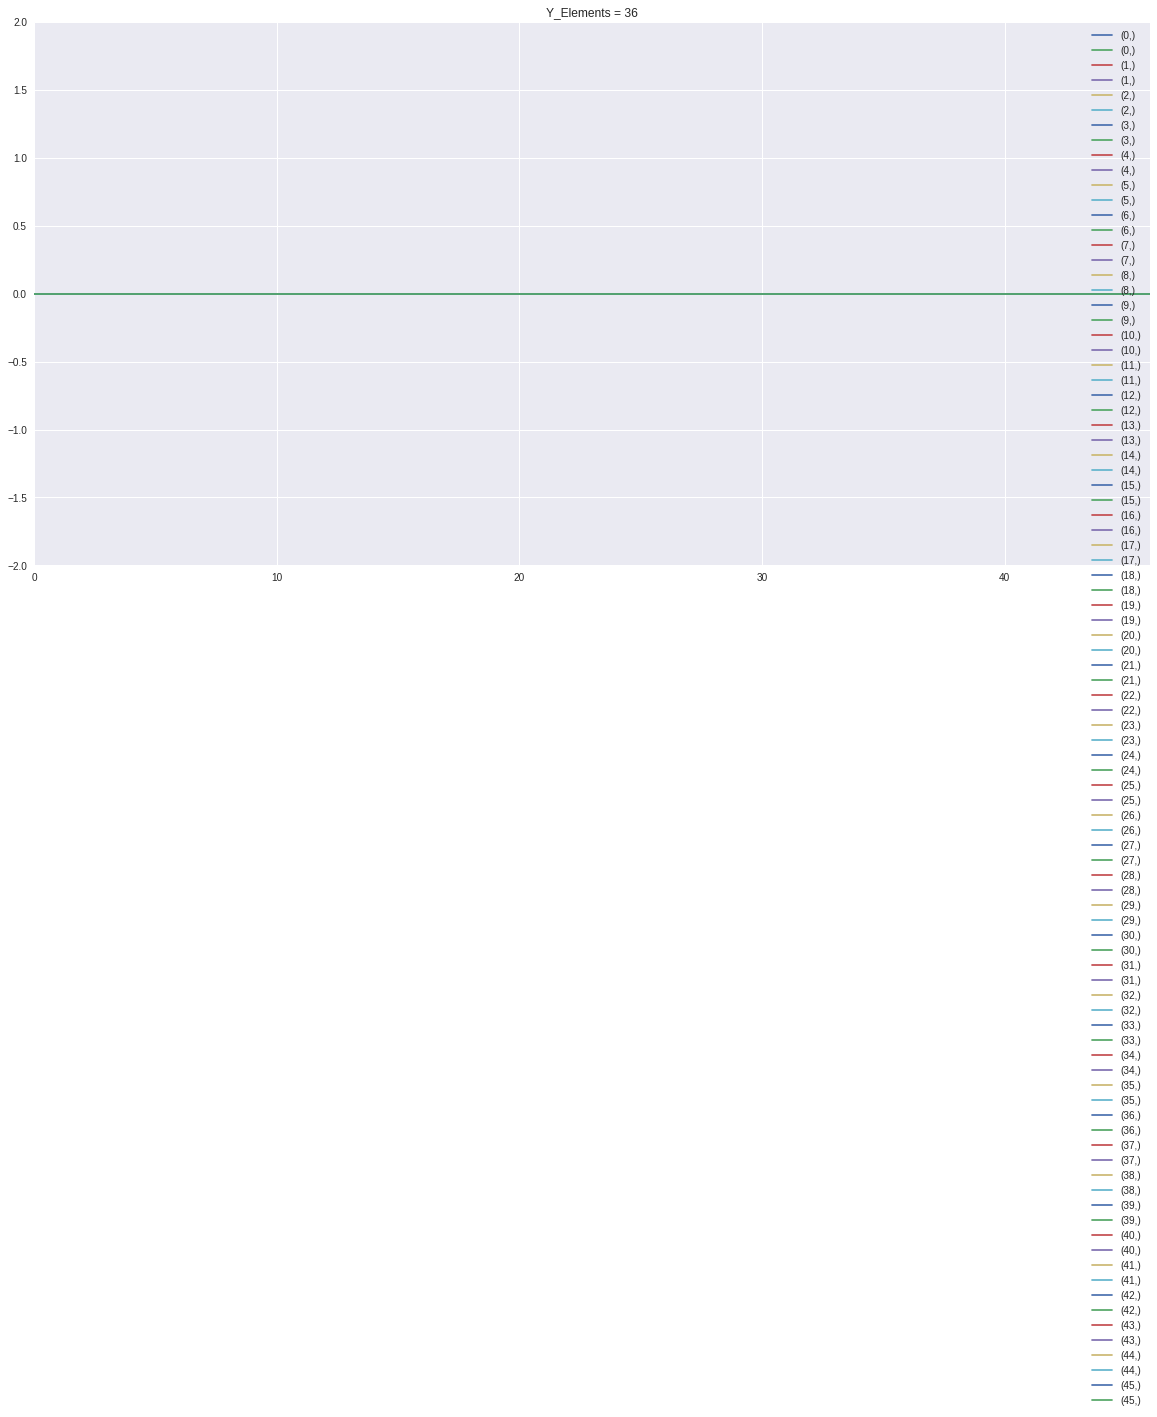

In [17]:
if no_of_dimensions > 1:

    xelements = no_of_elements[0]
    yelements = no_of_elements[1]
    plots = 5
    timestep_min = 0
    timestep_max = 500

    for plt in range(plots):

        y_axis_to_plot = int(plt*yelements/plots)
        mp.pyplot.figure(figsize = (20,10))
        mp.pyplot.axis([0,xelements, -2,2])

        

        for indices, element in np.ndenumerate( A[0:xelements, y_axis_to_plot] ):
            mp.pyplot.plot(range(timestep_min,timestep_max ), element.E[timestep_min:timestep_max], label = indices)
            mp.pyplot.title("Y_Elements = {0}".format(y_axis_to_plot))
        mp.pyplot.legend()


<h3> Scratch </h3>

In [18]:
E_field = np.array([np.zeros(np.shape(A)) for t in range(no_of_timesteps)])

for t in range(no_of_timesteps):
    for index, elem in np.ndenumerate(E_field[t,:,:]):
        E_field[t][index] = sum(np.round_((A[index].E[t]),decimals = 10))
        if E_field[t][index] ==0:
            continue

E_field.astype(np.float32)
    
#mp.pyplot.contour(E_field[10])
print(E_field[20])

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.00318457 -0.00048089 ...  0.          0.
   0.        ]
 [ 0.         -0.00048089  0.02693629 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [19]:
%matplotlib inline
def time_varying_contour(x):
    mp.pyplot.figure(figsize = (20,10))
    the_contourf = mp.pyplot.contour(E_field[x])
    mp.pyplot.colorbar()
    


widgets.interact( time_varying_contour , x = widgets.IntSlider( min = 1, max = no_of_timesteps -1))



NameError: ignored

In [20]:
% matplotlib inline
from mpl_toolkits.mplot3d import Axes3D


coordinates_x = np.array([elem.coordinates[0] for index,elem in np.ndenumerate(A)]).reshape(no_of_elements)
coordinates_y = np.array([elem.coordinates[1] for index, elem in np.ndenumerate(A)]).reshape(no_of_elements)

    
def time_varying_3d_contour(t):
    fig = mp.pyplot.figure(figsize = (20,10))
    ax = mp.pyplot.gcf().add_subplot(1,1,1, projection = '3d')
    ax.view_init(30,-35)
    the_contourf = ax.plot_surface( coordinates_x, coordinates_y, E_field[t], cmap = mp.cm.plasma)
    

    

widgets.interact( time_varying_3d_contour , t = widgets.IntSlider( min = 1, max = no_of_timesteps -1))
angle = widgets.interact( angle = widgets.IntSlider( min = 1, max = no_of_timesteps -1))



NameError: ignored

In [21]:
%matplotlib inline


@widgets.interact(t = (0,no_of_timesteps-1, 5), elevation = (0,360), azimuth = (0,360))
def manual(t = 0, elevation = 30, azimuth = 30):
    fig = mp.pyplot.figure(figsize = (20,10))
    ax = fig.add_subplot(1,1,1,projection = '3d')
    ax.view_init(elevation,azimuth)
    the_contourf = ax.plot_surface( coordinates_x, coordinates_y, E_field[t], cmap = mp.cm.plasma)
    


NameError: ignored

In [22]:
%matplotlib notebook

from matplotlib import animation
from matplotlib.animation import FuncAnimation

fig = mp.pyplot.figure(figsize = (10,5))
ax = mp.pyplot.gcf().add_subplot(1,1,1,projection = '3d')
ax.view_init(60,-60)
ax.set_zlim(-0.125, 0.125)
surface = ax.plot_surface( coordinates_x, coordinates_y, E_field[0])

def init():
        pass
    

def animate_t(t):
    ax.cla()
    surface = ax.plot_surface( coordinates_x, coordinates_y, E_field[t])
    ax.set_zlim(-0.25, 0.25)
    
        
ani = FuncAnimation(fig, animate_t, np.arange(10,no_of_timesteps,10), init_func = init, interval = 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py", line 1560, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'
